In [50]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

FINALS_CSV = "data_raw/finals_boston_universities.csv"
TRENDS_CSV = "data_raw/trends_us_ma_2019_to_today.csv"
OUTDIR     = "slides/figs"
os.makedirs(OUTDIR, exist_ok=True)

finals = pd.read_csv(FINALS_CSV)
trends = pd.read_csv(TRENDS_CSV, parse_dates=["date"])

for c in ["finals_start","finals_end"]:
    finals[c] = pd.to_datetime(finals[c], errors="coerce")
finals = finals.dropna(subset=["finals_start","finals_end"])

def week_start(d):
    d = pd.to_datetime(d).normalize()
    return (d - pd.to_timedelta(d.weekday(), unit="D"))

expanded = []
for _, r in finals.iterrows():
    d = r["finals_start"].normalize()
    while d <= r["finals_end"].normalize():
        expanded.append({"date": d, "school": r["school"]})
        d += pd.Timedelta(days=1)

if expanded:
    daily = pd.DataFrame(expanded)
    daily["week_start"] = daily["date"].apply(week_start)
    finals_weekly = (
        daily.groupby("week_start")["school"].nunique()
        .reset_index(name="finals_school_count_week")
    )
    finals_weekly["is_finals_week"] = (finals_weekly["finals_school_count_week"] > 0).astype(int)
else:
    finals_weekly = pd.DataFrame(columns=["week_start","finals_school_count_week","is_finals_week"])

if finals_weekly.empty:
    print("⚠️ No finals weeks found; the chart will show no shading.")


wk = pd.DataFrame({"week_start": pd.date_range("2018-12-31", pd.Timestamp.today(), freq="W-MON")})
wk["month_start"] = wk["week_start"].values.astype("datetime64[M]")
m = trends.copy()
m["month_start"] = m["date"].values.astype("datetime64[M]")
m = m.set_index("month_start")[["pizza_near_me","coffee_near_me"]]
weekly = wk.merge(m, left_on="month_start", right_index=True, how="left").drop(columns=["month_start"])
weekly[["pizza_near_me","coffee_near_me"]] = weekly[["pizza_near_me","coffee_near_me"]].ffill()

weekly = weekly.merge(finals_weekly, on="week_start", how="left").fillna(
    {"finals_school_count_week":0, "is_finals_week":0}
)
weekly["year"] = weekly["week_start"].dt.year
weekly["month"] = weekly["week_start"].dt.month
weekly["pizza_ma4"]  = weekly["pizza_near_me"].rolling(4, min_periods=1).mean()
weekly = weekly.sort_values("week_start").reset_index(drop=True)


In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.titlesize"] = 15
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["axes.edgecolor"] = "#EF6922"
mpl.rcParams["axes.linewidth"] = 0.8
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["xtick.color"] = "#222222"
mpl.rcParams["ytick.color"] = "#222222"
mpl.rcParams["grid.linestyle"] = "--"
mpl.rcParams["grid.alpha"] = 0.15

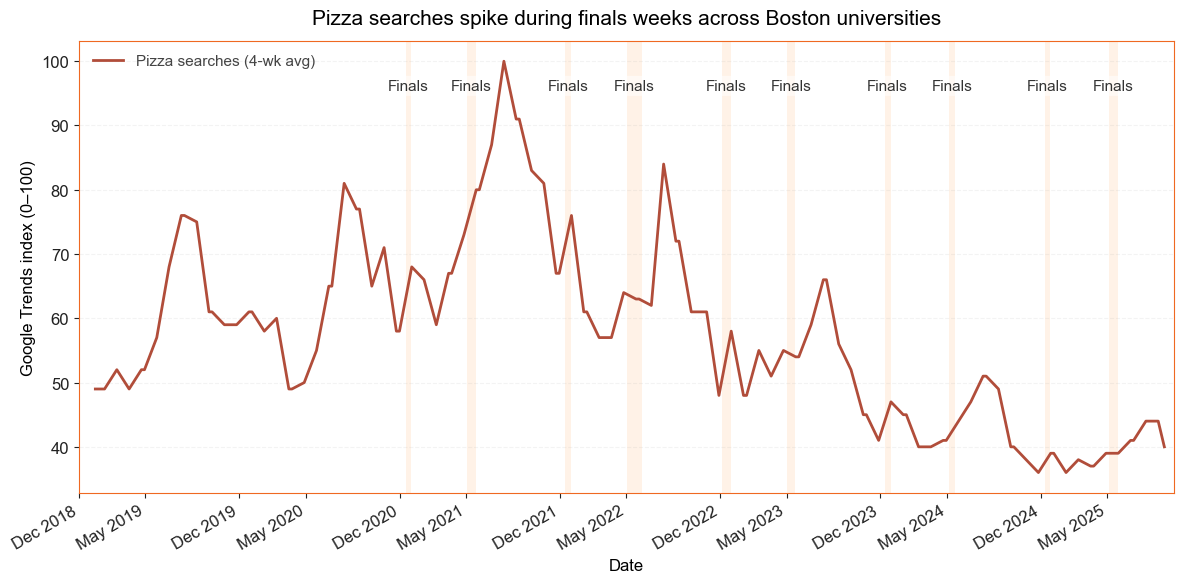

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

wk = weekly.copy()

wk = wk[(wk["finals_school_count_week"] > 0) & (wk["month"].isin([5, 12]))].copy()
wk["year_month"] = wk["week_start"].dt.to_period("M")  

spans = []
if not wk.empty:
    g = wk.groupby("year_month")["week_start"]
    for ym, weeks in g:
        s = weeks.min()
        e = weeks.max() + pd.Timedelta(days=6)  
        spans.append((s.normalize(), e.normalize()))

spans = sorted(spans, key=lambda x: (x[0].year, x[0].month))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    weekly["week_start"], 
    weekly["pizza_ma4"], 
    linewidth=2, 
    color="#B14D3A", 
    label="Pizza searches (4-wk avg)"
)

ax.legend(
    loc="upper left", 
    frameon=False, 
    fontsize=11, 
    labelcolor="#444"
)

for s, e in spans:
    ax.axvspan(s, e, color="#ffba7d", alpha=0.18, lw=0)
    if (e - s).days >= 10:
        x_mid = s + (e - s) / 2
        y_low, y_high = ax.get_ylim()
        y_text = y_low + 0.90 * (y_high - y_low)
        ax.text(x_mid, y_text, "Finals", ha="center", va="center",
                fontsize=11, color="#333",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.55, edgecolor="none"))

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[5, 12]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

xmin = weekly["week_start"].min().replace(day=1)
xmax = (weekly["week_start"].max().replace(day=1) + pd.offsets.MonthEnd(0))
ax.set_xlim(xmin, xmax)

# titles/labels
ax.set_title("Pizza searches spike during finals weeks across Boston universities", pad=12)
ax.set_ylabel("Google Trends index (0–100)")
ax.set_xlabel("Date")
ax.grid(axis="y", linestyle="--", alpha=0.15)

fig.tight_layout()
import os; os.makedirs("slides/figs", exist_ok=True)
fig.savefig("slides/figs/01_trend_finals_clean.png", dpi=200, bbox_inches="tight")
plt.show()

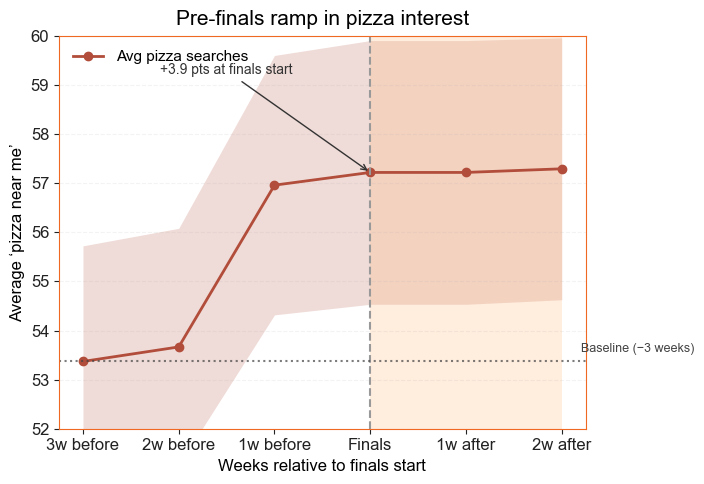

In [ ]:
import pandas as pd, matplotlib.pyplot as plt
import numpy as np

wins = finals[["finals_start","finals_end"]].dropna().drop_duplicates().sort_values("finals_start")

def wk0(d): 
    d = pd.to_datetime(d)
    return d - pd.to_timedelta(d.weekday(), unit="D")

rows = []
for _, w in wins.iterrows():
    start_wk = wk0(w["finals_start"])
    if start_wk.month not in (5,12): 
        continue
    for k in range(-3, 3):     
        wkdate = start_wk + pd.Timedelta(weeks=k)
        m = weekly.loc[weekly["week_start"]==wkdate]
        if not m.empty:
            rows.append({"rel_week": k, "pizza": float(m["pizza_near_me"].iloc[0])})

rel = pd.DataFrame(rows)

avg = rel.groupby("rel_week")["pizza"].mean()
sem = rel.groupby("rel_week")["pizza"].sem()

fig, ax = plt.subplots(figsize=(7.2,5))

ax.fill_between(avg.index, avg-sem, avg+sem, 
                color="#B14D3A", alpha=0.2, lw=0)

ax.plot(avg.index, avg, marker="o", linewidth=2, color="#B14D3A", label="Avg pizza searches")

ax.axvline(0, linestyle="--", color="#999")

ax.axvspan(0, 2, color="#ffba7d", alpha=0.25, lw=0)

baseline = avg.loc[-3]
ax.axhline(baseline, linestyle=":", color="#444", alpha=0.7)
ax.text(2.2, baseline+0.2, "Baseline (−3 weeks)", color="#444", fontsize=9)

lift = avg.loc[0] - baseline
ax.annotate(f"+{lift:.1f} pts at finals start",
            xy=(0, avg.loc[0]), xycoords="data",
            xytext=(-2.2, avg.loc[0]+2), textcoords="data",
            arrowprops=dict(arrowstyle="->", color="#333"),
            fontsize=10, color="#333")

labels = {
    -3: "3w before",
    -2: "2w before",
    -1: "1w before",
     0: "Finals",
     1: "1w after",
     2: "2w after"
}
ax.set_xticks(list(labels.keys()))
ax.set_xticklabels(list(labels.values()))

ax.set_ylim(52, 60)  

ax.set_xlabel("Weeks relative to finals start")
ax.set_ylabel("Average ‘pizza near me’")
ax.set_title("Pre-finals ramp in pizza interest")
ax.grid(axis="y", linestyle="--", alpha=0.15)
ax.legend(frameon=False, loc="upper left")

fig.tight_layout()
fig.savefig("slides/figs/04_event_study_polished.png", dpi=220, bbox_inches="tight")
plt.show()



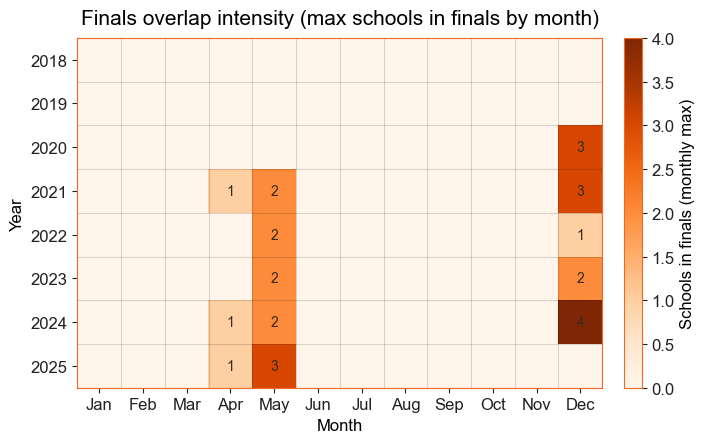

In [ ]:
import calendar
import numpy as np
import matplotlib.pyplot as plt

wm = (
    weekly
    .assign(year=weekly["week_start"].dt.year, month=weekly["week_start"].dt.month)
    .groupby(["year","month"])["finals_school_count_week"]
    .max()
    .reset_index()
)

years  = sorted(wm["year"].unique())
months = list(range(1,13))

mat = np.zeros((len(years), 12), dtype=float)
for i, y in enumerate(years):
    row = wm[wm["year"] == y].set_index("month")["finals_school_count_week"]
    for m in months:
        mat[i, m-1] = row.get(m, 0)

fig, ax = plt.subplots(figsize=(12, 4.6))

im = ax.imshow(mat, cmap="Oranges", vmin=0, vmax=max(1, mat.max()))

ax.set_xticks(np.arange(12))
ax.set_xticklabels([calendar.month_abbr[m] for m in months])
ax.set_yticks(np.arange(len(years)))
ax.set_yticklabels(years)
ax.set_xlabel("Month")
ax.set_ylabel("Year")
ax.set_title("Finals overlap intensity (max schools in finals by month)", pad=10)

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = int(mat[i, j])
        if val > 0:
            ax.text(j, i, str(val), ha="center", va="center", color="#3a2a20", fontsize=10)

ax.set_xticks(np.arange(-.5, 12, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(years), 1), minor=True)
ax.grid(which='minor', color=(0,0,0,0.08), linestyle='-', linewidth=0.8)
ax.tick_params(which='minor', bottom=False, left=False)

cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("Schools in finals (monthly max)")

fig.tight_layout()
os.makedirs("slides/figs", exist_ok=True)
fig.savefig("slides/figs/03_finals_overlap_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()


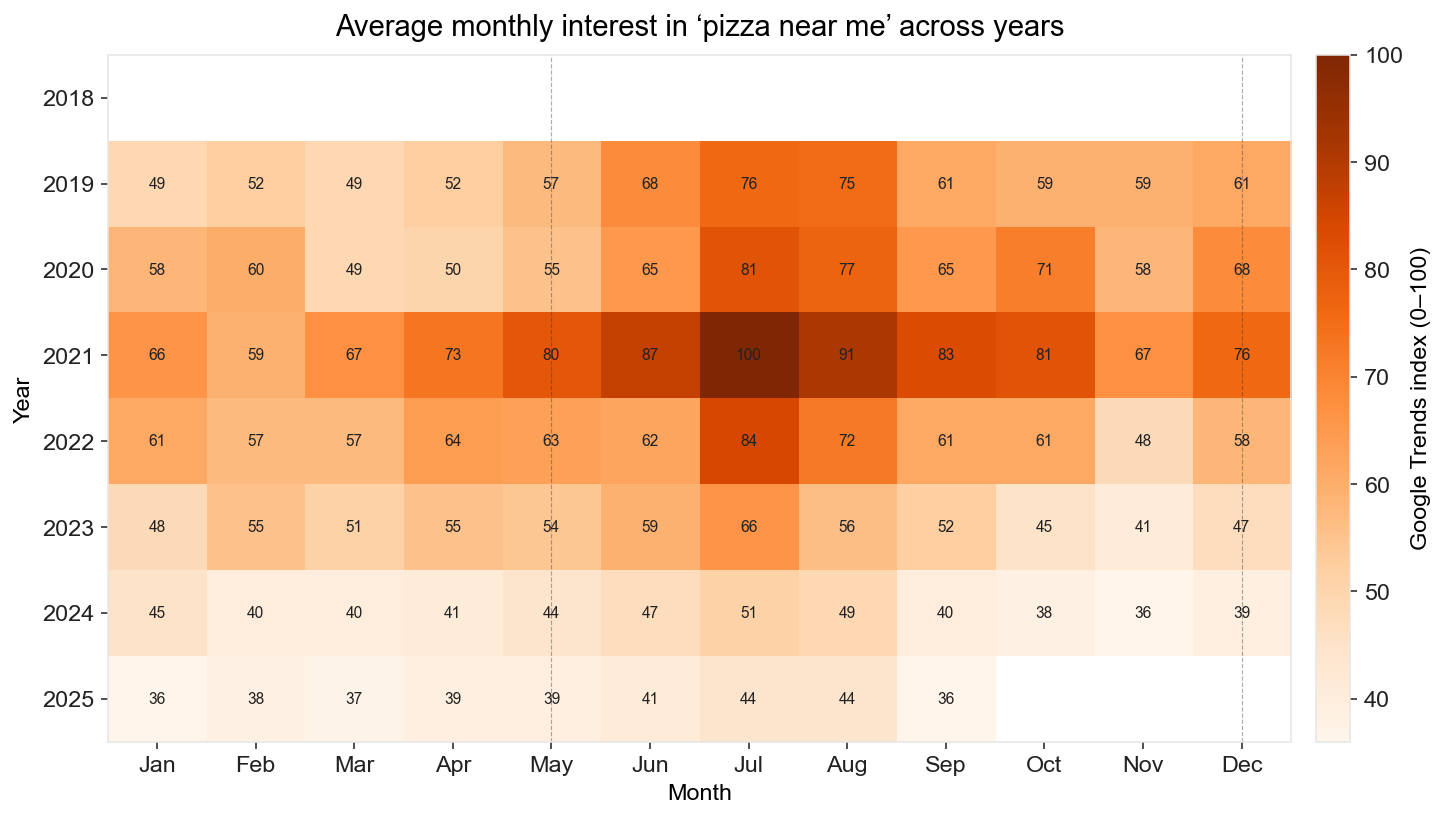

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

wm = weekly.copy()
wm["year"] = wm["week_start"].dt.year
wm["month"] = wm["week_start"].dt.month

month_avg = wm.groupby(["year","month"])["pizza_near_me"].mean().reset_index()
heat = month_avg.pivot(index="year", columns="month", values="pizza_near_me").sort_index()

fig, ax = plt.subplots(figsize=(10.5, 6), dpi=140)

im = ax.imshow(
    heat.values,
    aspect="auto",
    cmap="Oranges",
    vmin=np.nanmin(heat.values),
    vmax=np.nanmax(heat.values)
)

ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xticks(range(12))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

ax.set_title("Average monthly interest in ‘pizza near me’ across years", pad=10)
ax.set_xlabel("Month")
ax.set_ylabel("Year")

for m in [5, 12]:
    ax.axvline(m-1, color="#333", linestyle="--", linewidth=0.6, alpha=0.4)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=8, color="#222")

cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("Google Trends index (0–100)")

fig.tight_layout()
os.makedirs("slides/figs", exist_ok=True)
fig.savefig("slides/figs/03_year_month_heatmap.png", bbox_inches="tight")
plt.show()


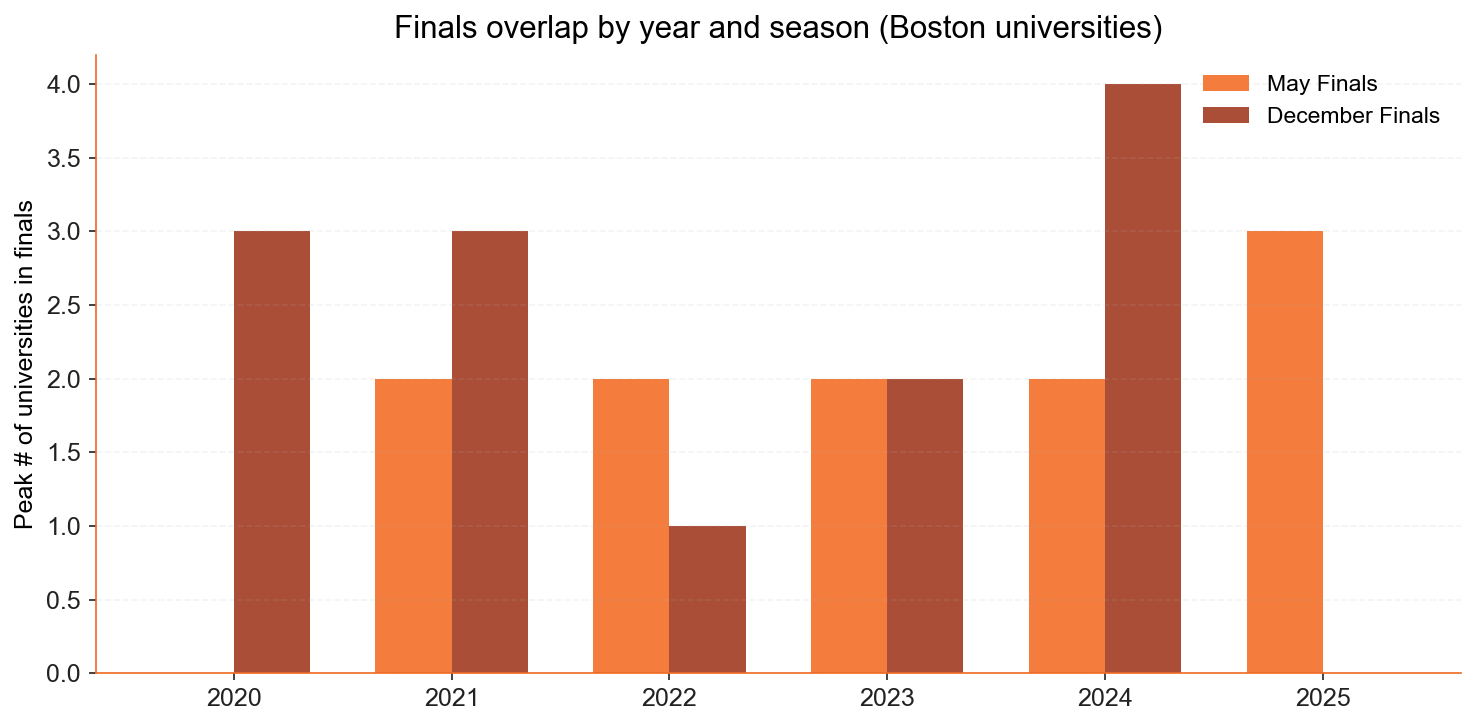

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

outdir = "slides/figs"
os.makedirs(outdir, exist_ok=True)

w = weekly.copy()
w["year"]  = w["week_start"].dt.year
w["month"] = w["week_start"].dt.month
w["season"] = np.where(w["month"].eq(5), "May",
                np.where(w["month"].eq(12), "Dec", None))
w = w[(w["season"].notna()) & (w["year"] >= 2020)]

peaks = (w.groupby(["year","season"])["finals_school_count_week"]
           .max()
           .reset_index())

pivot = peaks.pivot(index="year", columns="season", values="finals_school_count_week").fillna(0)

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

bar_width = 0.35
x = np.arange(len(pivot.index))

ax.bar(x - bar_width/2, pivot["May"], width=bar_width, color="#F47C3C", label="May Finals")
ax.bar(x + bar_width/2, pivot["Dec"], width=bar_width, color="#AB4E37", label="December Finals")

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=0)
ax.set_ylabel("Peak # of universities in finals")
ax.set_title("Finals overlap by year and season (Boston universities)")
ax.legend(frameon=False)
ax.spines[['top','right']].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.15)

fig.tight_layout()
fig.savefig(os.path.join(outdir, "03_finals_overlap_grouped.png"), dpi=200, bbox_inches="tight")
plt.show()


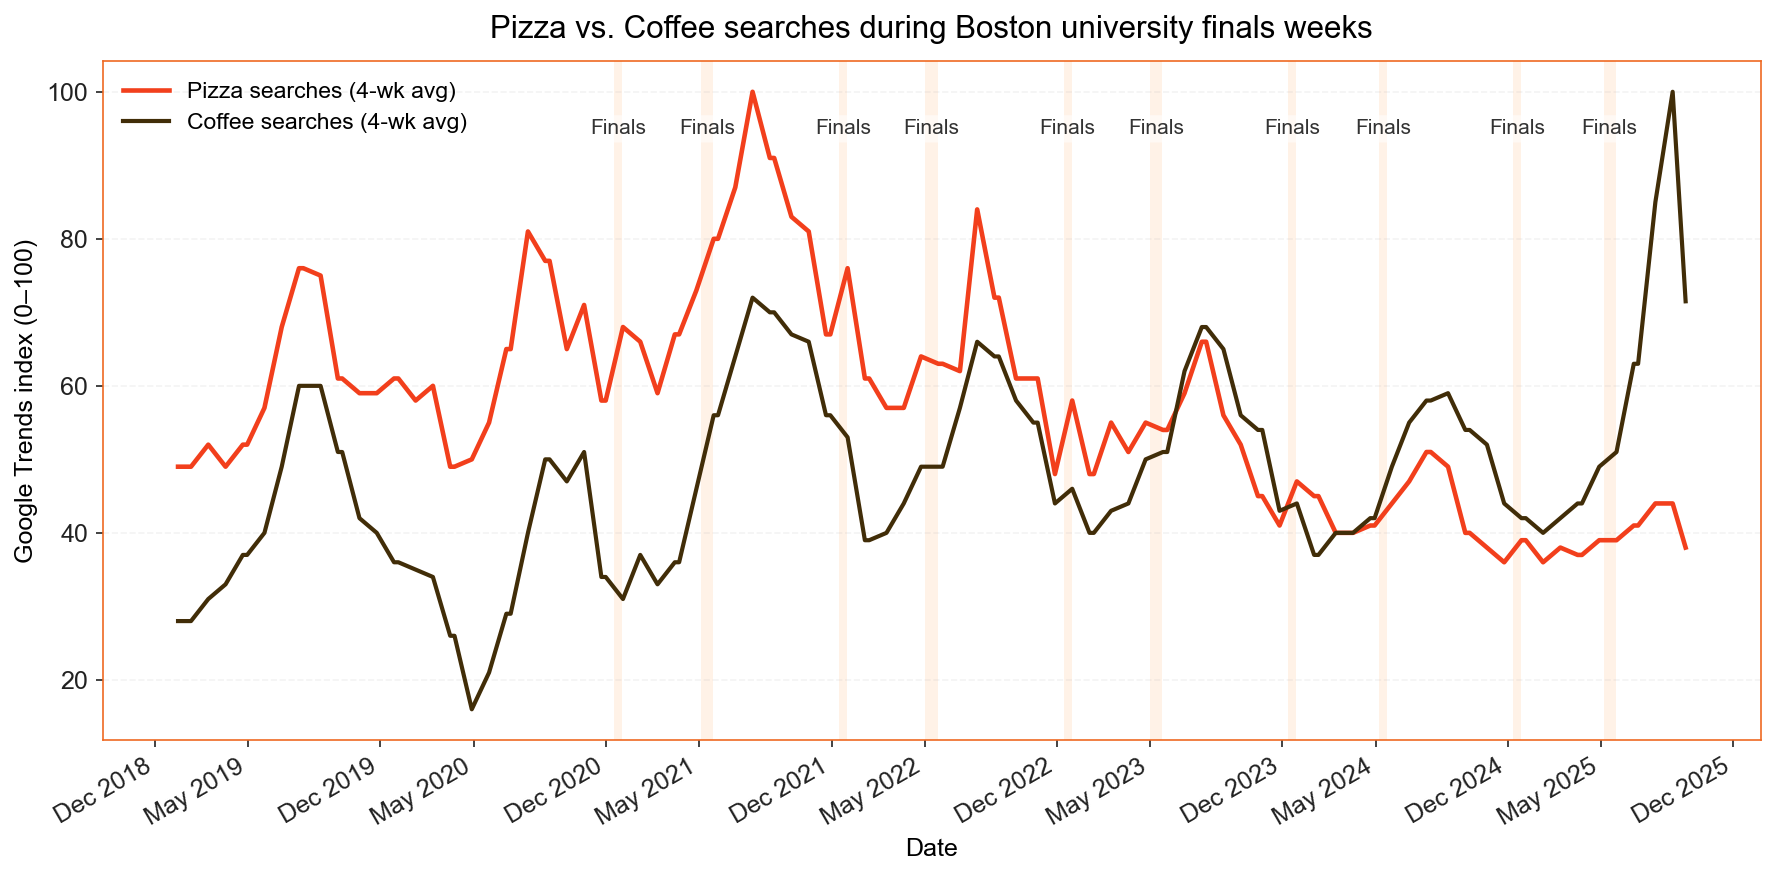

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

outdir = "slides/figs"
os.makedirs(outdir, exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax.plot(
    weekly["week_start"], 
    weekly["pizza_ma4"], 
    linewidth=2.2, 
    color="#F23F1C", 
    label="Pizza searches (4-wk avg)"
)

ax.plot(
    weekly["week_start"], 
    weekly["coffee_near_me"].rolling(4, min_periods=1).mean(), 
    linewidth=2.0, 
    color="#412D08", 
    label="Coffee searches (4-wk avg)"
)

wk = weekly[(weekly["finals_school_count_week"] > 0) & (weekly["month"].isin([5, 12]))].copy()
wk["year_month"] = wk["week_start"].dt.to_period("M")

spans = []
if not wk.empty:
    g = wk.groupby("year_month")["week_start"]
    for ym, weeks in g:
        s = weeks.min()
        e = weeks.max() + pd.Timedelta(days=6)  
        spans.append((s.normalize(), e.normalize()))

for s, e in spans:
    ax.axvspan(s, e, color="#ffba7d", alpha=0.18, lw=0)
    if (e - s).days >= 7:
        x_mid = s + (e - s) / 2
        y_low, y_high = ax.get_ylim()
        y_text = y_low + 0.9 * (y_high - y_low)
        ax.text(x_mid, y_text, "Finals", ha="center", va="center",
                fontsize=10, color="#333",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.55, edgecolor="none"))

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[5, 12]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

ax.set_title("Pizza vs. Coffee searches during Boston university finals weeks", pad=11)
ax.set_ylabel("Google Trends index (0–100)")
ax.set_xlabel("Date")

ax.legend(loc="upper left", frameon=False)

ax.grid(axis="y", linestyle="--", alpha=0.15)

fig.tight_layout()
fig.savefig(os.path.join(outdir, "03_pizza_vs_coffee.png"), dpi=200, bbox_inches="tight")
plt.show()
